In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rand
import math

from collections import deque
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [4]:
real_data = pd.read_excel('./documents/nov_nine_var.xlsx').to_numpy()
goal_data = pd.read_excel('./documents/result/basic_formula.xlsx').to_numpy()

scaler = MinMaxScaler()
scaler = scaler.fit(real_data[:,1:22])

In [5]:
def load_data(data, i):
    data = scaler.transform(data[:,1:22])[i].reshape(1, 21)

    return np.round(data, 2)

def argmax(l):
    return max(range(len(l)), key=lambda i: l[i])

def argmin(l):
    return min(range(len(l)), key=lambda i: l[i])

In [6]:
start = load_data(real_data, -1)
goal = load_data(goal_data, argmin(goal_data[:,-1]))

print(goal[0])
print(start[0])

need_step = int(np.sum(abs(goal-start))*100)
print(need_step)

[0.51 0.5  0.5  0.49 0.5  0.5  0.5  0.5  0.5  0.5  0.49 0.5  0.5  0.5
 0.5  0.5  0.49 0.49 0.51 0.5  0.5 ]
[0.   0.98 0.   1.   0.99 1.   0.   0.78 0.09 0.46 0.4  0.58 0.27 0.32
 0.23 0.23 1.   0.03 0.5  0.43 1.  ]
689


In [7]:
# dqn paramater
GAMMA = 0.99
EPS_DECAY = 0.0005
BATCH_SIZE = 64
TRAIN_FLAG = 100000
MEMORY_SIZE = 1000000
EPISODE_DONE = need_step * 100

LEARN_FREQ = 50

ACTION_NUM = 42

In [8]:
def return_action(i):
    a = np.zeros((1, 21))
    j = i // 2

    if i % 2 == 0:
        a[0][j] = -0.01
    
    else:
        a[0][j] = 0.01
    
    return a

In [9]:
def return_state(s, a):
    ns = s + a
    return ns

In [10]:
def return_reward(ns, gs):
    dist = np.sqrt(np.sum(np.square(gs - ns)))

    end = 0
    for i in range(21):
        if ns[0][i] == gs[0][i]:
            end += 4
    
    reward = -dist + end
    return reward

In [11]:
def argmax(l):
    return max(range(len(l)), key=lambda i: l[i])

In [12]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.8
    beta = 0.3
    beta_increment_per_sampling = 0.0005

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (np.abs(error) + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        a_is = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = rand.uniform(a, b)
            (a_i, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            a_is.append(a_i)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, a_is, is_weight

    def update(self, a_i, error):
        p = self._get_priority(error)
        self.tree.update(a_i, p)

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, a_i, change):
        parent = (a_i - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, a_i, s):
        left = 2 * a_i + 1
        right = left + 1

        if left >= len(self.tree):
            return a_i

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        a_i = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(a_i, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, a_i, p):
        change = p - self.tree[a_i]

        self.tree[a_i] = p
        self._propagate(a_i, change)

    # get priority and sample
    def get(self, s):
        a_i = self._retrieve(0, s)
        dataa_i = a_i - self.capacity + 1

        return (a_i, self.tree[a_i], self.data[dataa_i])

In [13]:
class DQN_Network(tf.keras.models.Model):
    def __init__(self):
        super(DQN_Network, self).__init__()
        self.input_layer = tf.keras.layers.Dense(128, activation='relu')

        self.q_layer = tf.keras.models.Sequential()
        self.q_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.q_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.q_layer.add(tf.keras.layers.Dense(1, activation='linear'))

        self.adv_layer = tf.keras.models.Sequential()
        self.adv_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.adv_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.adv_layer.add(tf.keras.layers.Dense(ACTION_NUM, activation='linear'))
    
    def call(self, x):
        i = self.input_layer(x)

        q = self.q_layer(i)
        adv = self.adv_layer(i)

        o = q + adv - tf.math.reduce_mean(adv, axis=1, keepdims=True)
        return o

In [14]:
class DQN_Agent:
    def __init__(self):
        self.train_model = self.set_model()
        self.target_model = self.set_model()
        self.target_model.trainable = False

        self.memory = Memory(MEMORY_SIZE)
        self.episode = 1
        self.eps_threshold = 1

        self.optim = tf.keras.optimizers.RMSprop(learning_rate=1e-11)

    def set_model(self):
        net = DQN_Network()
        net.build(input_shape=(1, 21))

        optim = tf.keras.optimizers.RMSprop(learning_rate=1e-11)
        net.compile(optimizer=optim, loss='mse')
        return net

    def update_model(self):
        self.target_model.set_weights(self.train_model.get_weights())

    def soft_update_model(self):
        train_weight = np.array(self.train_model.get_weights(), dtype=object)
        target_weight = np.array(self.target_model.get_weights(), dtype=object)

        weight = train_weight * 0.01 + target_weight * 0.99
        self.target_model.set_weights(weight)

    def memorize(self, cs, a_i, r, ns, d):
        if d and self.memory.tree.n_entries > TRAIN_FLAG:
            self.episode += 1

        td_error = r + GAMMA * np.argmax(self.target_model(ns)[0]) - np.argmax(self.train_model(cs)[0])
        self.memory.add(td_error, (cs, a_i, r, ns, d))

    def convert_memory_to_input(self, batch):
        s, a_i, r, ns, d = zip(*batch)

        states = tf.convert_to_tensor(s).reshape(BATCH_SIZE, 21)
        action_indexs = tf.convert_to_tensor(a_i)
        rewards = tf.convert_to_tensor(r)
        next_states = tf.convert_to_tensor(ns).reshape(BATCH_SIZE, 21)
        dones = tf.convert_to_tensor(d)

        return states, action_indexs, rewards, next_states, dones

    def act(self, state):
        a_r = np.array(self.train_model(state))[0]

        if rand.random() > self.eps_threshold:
            a_i = np.argmax(a_r)
            c = 1

        else:
            a_i = rand.randint(0, ACTION_NUM-1)
            c = 0

        return a_i, c, self.eps_threshold

    def run(self):
        if self.memory.tree.n_entries < TRAIN_FLAG:
            return 1
        
        self.eps_threshold = 0.05 + (1 - 0.05) * math.exp(-1. * self.episode * EPS_DECAY)

        batch, a_is, is_weight = self.memory.sample(BATCH_SIZE)

        states, action_indexs, rewards, next_states, dones = self.convert_memory_to_input(batch)
        is_weight = tf.convert_to_tensor(is_weight)
        loss = self.learn(states, action_indexs, rewards, next_states, dones, is_weight)

        return loss.numpy()

    @tf.function
    def learn(self, states, action_indexs, rewards, next_states, dones, is_weight):
        
        with tf.GradientTape() as tape:
            tape.watch(self.train_model.trainable_variables)

            q = self.train_model(states)
            next_q = self.train_model(next_states)
            next_target_q = self.target_model(next_states)

            next_action = tf.argmax(next_q, axis=1)

            target_val = tf.reduce_sum(tf.one_hot(next_action, ACTION_NUM) * next_target_q, axis=1)
            target_q = rewards + (1 - dones) * GAMMA * target_val

            main_val = tf.reduce_sum(tf.one_hot(action_indexs, ACTION_NUM) * q, axis=1)

            error = tf.square(main_val - target_val) * 0.5
            loss = tf.reduce_mean(error)

        grads = tape.gradient(loss, self.train_model.trainable_weights)
        grads = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in grads]
        self.optim.apply_gradients(zip(grads, self.train_model.trainable_weights))

        return loss

In [16]:
agent = DQN_Agent()
state_hist = []
reward_hist = [[] for i in range(4)]
loss_hist = []
eps_hist = []
steps_list = []

for e in range(20000 + TRAIN_FLAG // EPISODE_DONE):
    # counter = [0 for i in range(42)]
    state = start
    steps = 1
    reward = return_reward(state, goal)
    rewards = 0
    # min_reward = 100
    # max_reward = -100
    # c = 0

    # if e % 500 == 0:
    #     agent.update_model()
    #     print("===update===")

    while True:
        a_i, t, eps = agent.act(state)
        action = return_action(a_i)
        # counter[a_i] += 1
        # c += t

        if steps == EPISODE_DONE or all(state[0] == goal[0]):
            done = 1
        else:
            done = 0

        next_state = return_state(state, action)
        reward = return_reward(next_state, goal)

        agent.memorize(state, a_i, reward, next_state, done)
        if steps % LEARN_FREQ == 0:
            loss = agent.run()
            agent.soft_update_model()
        
        state = next_state
        rewards += reward
        steps += 1

        # if reward < min_reward:
        #     min_reward = reward

        # if reward > max_reward:
        #     max_reward = reward

        # steps_list.append(reward)
        # state_hist.append(state)

        if done:
            rewards = rewards if steps - 1 == EPISODE_DONE else -100
            reward_hist[0].append(rewards)
            # reward_hist[1].append(rewards/steps)
            # reward_hist[2].append(max_reward)
            # reward_hist[3].append(min_reward)
            # loss_hist.append(loss)
            # eps_hist.append(eps)
            # steps_list.append(0 if steps - 1 == EPISODE_DONE else 1)
            print(f'============={e if steps -1 == EPISODE_DONE else 0}=============')
            # print(f"mean rewards: {round(rewards/steps, 3)}, net_loss: {round(loss, 3)}, most action: {argmax(counter)}|{max(counter)}/{steps}, greedy: {c}, eps: {round(eps, 5)}")
            # print(round(min_reward, 1), round(max_reward, 1), round(reward, 1))
            # print(state[0])

            break

=============0=============
=============1=============
=============2=============
=============3=============
=============4=============
=============5=============
=============6=============
=============7=============
=============8=============
=============9=============
=============10=============
=============11=============
=============12=============
=============13=============
=============14=============
=============15=============
=============16=============
=============17=============
=============18=============
=============19=============
=============20=============
=============21=============
=============22=============
=============23=============
=============24=============
=============25=============
=============26=============
=============27=============
=============28=============
=============29=============
=============30=============
=============31=============
=============32=============
=============33=============
=============34=========

KeyboardInterrupt: 

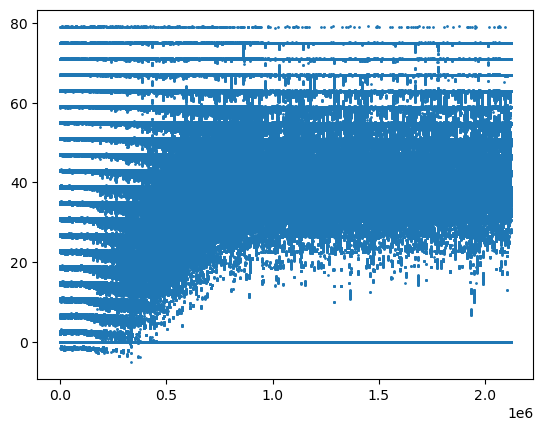

In [ ]:
plt.scatter([i for i in range(len(steps_list))], steps_list, s=1)
plt.show()

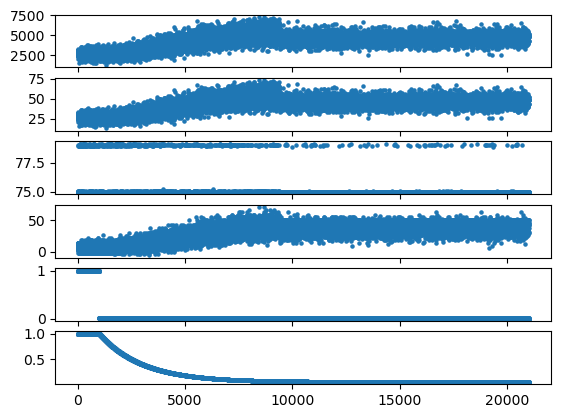

In [ ]:
plotting_list = [reward_hist[0], reward_hist[1], reward_hist[2], reward_hist[3], loss_hist, eps_hist] # sum, mean, max, min
for i, plotting in enumerate(plotting_list):
    plt.subplot(len(plotting_list), 1, i+1)
    plt.scatter([j for j in range(len(plotting))], plotting, s=5)

plt.show()

In [ ]:
np.max(reward_hist[2])

NameError: name 'np' is not defined

In [ ]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')
encoder = tf.keras.models.load_model('./model/encoder.h5')

done = False
state = start
state_list = []
while not done:
    state_list.append(state)
    if all(state[0] == goal[0]):
        done = True
    a, _, _ = agent.act(state)
    state = return_state(state, a)

p = dnn_model.predict(state_list)
e = encoder.predict(state_list)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


for s in e:
    ax.scatter(s[0], s[1], s[2])

plt.show()